In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

time: 167 ms


In [2]:
import scqubits as scq
import numpy as np

time: 380 ms


# Calculations and Visualization

scqubits allows us to predict and visualize the qubit coherence times due to various noise channels. 


## Basic noise calculations: noise channels
We start by instantiating a qubit object:

In [3]:
tune_tmon = scq.TunableTransmon(
    EJmax=20.0,
    EC=0.5,
    d=0.00,
    flux=0.1,
    ng=0.3,
    ncut=150
)

print(tune_tmon)

TUNABLETRANSMON
 ———— PARAMETERS ————
EJmax	: 20.0
EC	: 0.5
d	: 0.0
flux	: 0.1
ng	: 0.3
ncut	: 150
truncated_dim	: None
Hilbert space dimension	: 301
time: 1.03 ms


We can check what noise channels are supported by this qubit by calling

In [4]:
tune_tmon.supported_noise_channels()

['tphi_1_over_f_flux',
 'tphi_1_over_f_cc',
 'tphi_1_over_f_ng',
 't1_capacitive_loss',
 't1_flux_bias_line',
 't1_charge_impedance']

time: 2.8 ms


Any of the above listed channels corresponds to a method that can be called directly. For example, to calculate the pure-dephasing time $T_{\phi}$ due to $1/f$ flux noise (with its default parmeters), we execute:

In [5]:
tune_tmon.tphi_1_over_f_flux()

8088.317057546061

time: 7.85 ms


The above result is given in inverse frequncy units. The default frequency units in scqubits are GHz. One can check the currently active unit setting by calling

In [6]:
scq.get_units()

'GHz'

time: 1.55 ms


Given the setting to GHz, the units of time are 1/GHz=$ns$. Accordingly, the above dephasing time is given in $ns$.

Instad of times all the noise functions can also return rates - this is done by passing the ``get_rate=True`` argument. 
Each of the noise methods also takes a variety of other arguments, allowing one to specify information ranging from what energy levels should be used in the calculations, to various noise strenghts, and noise operators - see specific method documentations for details. 

As an example of some of the non-default options, we consider a $T_1$ noise process due to direct coupling of the qubit to a charge line. The effects of such a noise channel can be calculated using a method called ``t1_charge_impedance``. For example, suppose we wish the calculate the rate for transitions between the 3rd and 1st energy levels, assuming a standard transmission line at a temperature of T=100mK. To obtain the resulting rate, we execute: 

In [7]:
tune_tmon.t1_charge_impedance(i=3, j=1, T=0.100, get_rate=True, total=False)

5.615534273392123e-05

time: 6.74 ms


The option ``total=False`` in the above code signals that only the rate from level 3 to level 1 should be calculated, without inclusion of the upward (excitation) rate. The contribution from excitation processes is included by passing the option ``total=True`` (which is also the default for all the methods that consider $T_1$ processes).

## Effective noise calculations
scqubits can also approximate effectivive noise, which is calculated by considering total contributions from a variety of noise chennels (that can be given as an argument). In the case of a depolarization noise, the effective noise is obtained from 
\begin{equation}
\frac{1}{T_{1}^{\rm eff}} = \sum_k \frac{1}{T_{1}^{k}},
\end{equation}

where the sum runs over all the noise channels that the user wants included. By default those correpond to the the list returned by the `effective_noise_channels` method for each qubit. A differnt list of noise channels can be also provided as an argument by the user. 


Simliarly, users can calculate effective depahsing, which includes contributions from both pure dephasing, as well as depolarization channels. Such a $T_{2}$ time is defined as

\begin{equation}
\frac{1}{T_{2}^{\rm eff}} = \sum_k \frac{1}{T_{\phi}^{k}} +  \frac{1}{2} \sum_j \frac{1}{T_{1}^{j}}, 
\end{equation}

where $k$ ($j$) run over the relevant pure dephasing (depolariztion) channels that can contribute to the effective noise. 

To start with, let us see what noise channels are included in the default effective noise calculations in a `TunableTransmon` qubit:

In [8]:
tune_tmon.effective_noise_channels()

['tphi_1_over_f_flux',
 'tphi_1_over_f_cc',
 'tphi_1_over_f_ng',
 't1_capacitive_loss',
 't1_flux_bias_line']

time: 1.63 ms


Note that for some qubits, such as the Transmon, this list is different from all the `supported_noise_channels`, which in this case, is

In [9]:
tune_tmon.supported_noise_channels()

['tphi_1_over_f_flux',
 'tphi_1_over_f_cc',
 'tphi_1_over_f_ng',
 't1_capacitive_loss',
 't1_flux_bias_line',
 't1_charge_impedance']

time: 1.65 ms


As shown above the `supported_noise_channels` list contains an extra noise channel `t1_charge_impedance`. Since in most implementations, charge lines are not directly coupled to transmon qubits, this channel is by default not included in the effective noise calculations. 


Let us see what the effecitve $T_{1}$ time is

In [10]:
tune_tmon.t1_effective()

15644.923932573467

time: 7.19 ms


As well as the effective $T_{2}$

In [11]:
tune_tmon.t2_effective()

6341.746362164173

time: 8.14 ms


Users can also specify both what channels should be included in effective noise calculations, as well as what the various parameters should be. 
For example, to specify a smaller list of channels that we want to consdier, we can explicitly pass a channel list. We can also pass a common list of options as a dictionary, via the `common_noise_options` parameter. In the example below, we set the temperature to $T=0.050$K. The effects of `t1_charge_impedance` noise channel, are very damaging and dominant, as can be clearly seen by a small effective $T_{1}^{\rm eff}$ time.

In [12]:
tune_tmon.t1_effective(noise_channels=['t1_charge_impedance', 't1_flux_bias_line'], 
                       common_noise_options=dict(T=0.050))

0.195010281086235

time: 7.23 ms


Along with `common_noise_options`, channel-specific noise options can also be provided. This is done by replacing the a noise channel name with a tuple of the form `(name, noise_options)` where `noise_options` is a dictionary. 
In the example below, we calculate an effective $T_{2}^{\rm eff}$, with a non-default value of $1/f$ flux noise strength `A_flux` that internally gets passed to the qubit's `tphi_1_over_f_flux` method. 
                       

In [13]:
tune_tmon.t2_effective(noise_channels=['t1_flux_bias_line','t1_capacitive_loss',
                                      ('tphi_1_over_f_flux', dict(A_noise=3e-6))], 
                       common_noise_options=dict(T=0.050))

2482.0715515758156

time: 7.79 ms


## Visualization of coherence times 

A common way to understand and visualize how noise affects a given qubit, is to plot decoherence times as a function of one of the external parameters, such as the flux or charge offset. (Alternatively, it may be useful to consider how decoherence properties change as we vary one or more of the qubit's core energy parameters, such as $E_J$ or $E_C$).    Each noisy qubit provides a flexible method called ``plot_noise``, which facilitates this functionality. In the following, we give examples of some of this method's capabilities. 

To provide an overview of decoherence properties on, say, flux, the effect of all supported noise channels can be visualized one by one. (The calculated and plotted data are expressed in the currently set units, by default $ns$ and GHz, respectively.)

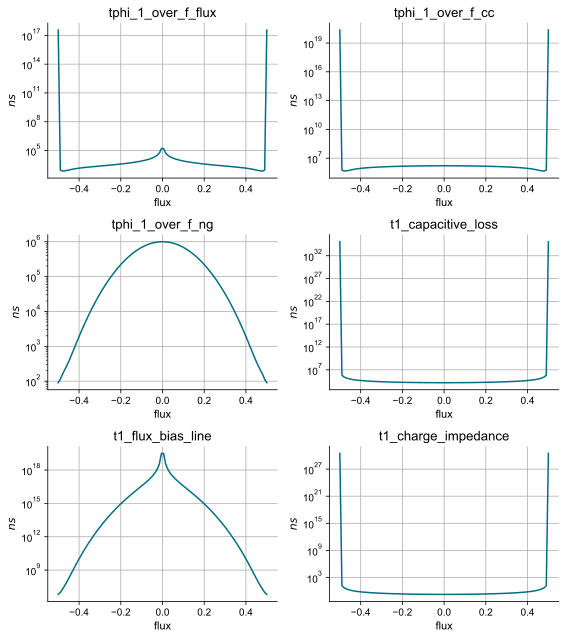

time: 1.73 s


In [14]:
tune_tmon.plot_coherence_vs_paramvals(param_name='flux', 
                                      param_vals=np.linspace(-0.5, 0.5, 100));

We can easily re-express the results in different time units by using the ``scale`` argument, for example ``scale=1e-3`` to convert times to $\mu s$. (Alternatively, before creating the qubit object, we could have changed the units to `MHz` via the ``set_units`` function.)

Instead of including all supported noise channels, we can also choose a few select ones. This is achieved by providing a list of specific noise channels that should be plotted. The plots can be customized either by passing plot options directly to the ``plot_coherence_vs_paramvals`` method, or by manipulating the properties of the matplotlib ``Axes`` object returned by ``plot_coherence_vs_paramvals``, as shown below.

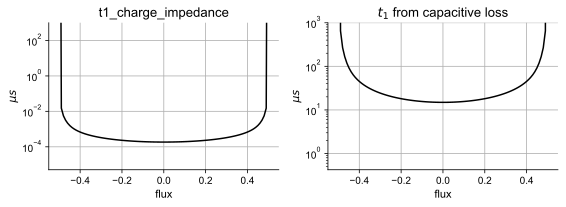

time: 621 ms


In [15]:
fig, ax = tune_tmon.plot_coherence_vs_paramvals(
    param_name='flux', 
    param_vals=np.linspace(-0.5, 0.5, 100), 
    noise_channels=['t1_charge_impedance', 't1_capacitive_loss'], 
    scale=1e-3, 
    ylabel=r"$\mu s$", 
    color='black', 
    ylim=(None, 1e3)
)

ax[1].set_title(r"$t_1$ from capacitive loss");   # customize the title

For additional control, we may choose to calculate coherences with non-default options for all the noise channels we want to plot. This can be done by passing a `common_noise_options` argument to `plot_coherence_vs_paramvals`, which contains a dictionary of option/value pairs. We can also choose different noise-specific options or each noise channel. This is possible by supplying the `noise_channels` argument with tuples containting (1) a noise-channel name, and (2) a dictionary with options that are internally used to calculate the noise. In the example below, we set a non-default temperature for all the provided noise channels to 100 $mK$, but also choose a non-default energy levels 3 and 2 for the ``t1_capacitive_loss`` noise channel calculation (instead of default 1 and 0).


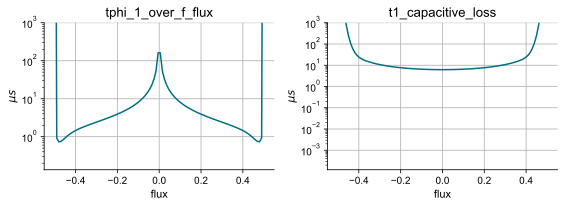

time: 843 ms


In [16]:
tune_tmon.plot_coherence_vs_paramvals(
                     param_name='flux',  
                     param_vals=np.linspace(-0.5, 0.5, 100), 
                     noise_channels = ['tphi_1_over_f_flux',
                                      ('t1_capacitive_loss', dict(i=3, j=2))],
                     common_noise_options=dict(T=0.100),
                     scale=1e-3, 
                     ylabel=r"$\mu s$", 
                     ylim=(None, 1e3)
                    );

## Visualization of effective noise

scqubits also provides methods to easily visualize how the effective $T_{1}$ and $T_{2}$ times vary as system parameters change. This is done via `plot_t1_effective_vs_paramvals` and `plot_t2_effective_vs_paramvals` methods. 
These work in a similar way to `plot_coherence_vs_paramvals`, except now if `noise_channels` list is passed as an argument, it now is used to specify which noise channels are used to calculate the effective noise. 

As the first example, let us explore how the effective $T_{1}^{\rm eff}$ noise of our tunable tranmon qubit varies as we change flux. Here we assume non-default temperature, as well as level transition, by passing an appropriate `common_noise_options` dictionary. 

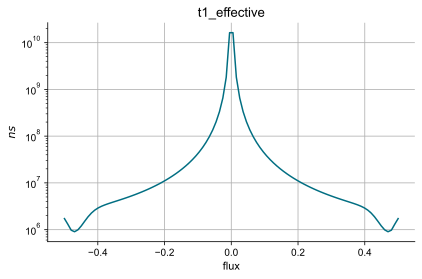

time: 576 ms


In [17]:
tune_tmon.plot_t1_effective_vs_paramvals(param_name='flux',
                            param_vals=np.linspace(-0.5, 0.5, 100), 
                            common_noise_options=dict(T=0.050, i=2, j=0));

We can also consider a more complicated example $T_{2}^{\rm eff}$ example, with a custom list of channels, and with custom plotting options. 

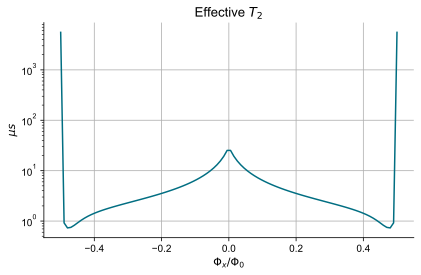

time: 617 ms


In [18]:
tune_tmon.plot_t2_effective_vs_paramvals(param_name='flux',
                            param_vals=np.linspace(-0.5, 0.5, 100),
                            noise_channels=['t1_capacitive_loss', 't1_flux_bias_line',
                                            ('tphi_1_over_f_flux', dict(A_flux=3e-6))], 
                            common_noise_options=dict(T=0.050),
                            scale=1e-3, 
                            ylabel=r"$\mu s$",   
                            xlabel=r"$\Phi_x/\Phi_0$",   
                            title=r"Effective $T_{2}$",
                            grid='red'
                            );

For more details on method signatures, see the API documentation [here][apilink]. 

[apilink]: https://scqubits.readthedocs.io/en/latest/api-doc/apidoc.html